In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys
from scipy.optimize import curve_fit

sys.path.insert(1, '../code')
from read_halos import SimulationReader
from fit import Fitter
from neural_net import NeuralNet, NNFitter
import plotter
import scalars

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = False
show_intermediate_plots = False
check_cond = False
plot_dir = '../plots/plots_2022-03-03_catalog'
if save_plots:
    !mkdir -p $plot_dir

In [3]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1' # don't have catalog features for TNG50-4
sim_name_dark = 'TNG100-1-Dark'

halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [4]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')

Must restrict to halo_mass_min=10^10.8 to be consistent with halo structure catalog!
https://www.tng-project.org/data/docs/specifications/#sec5q

In [5]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)

In [59]:
def fit_and_plot(fitter, log_m_halo, rms_x=True, log_x=False, log_y=False, 
                 test_error_type='percentile', regularization_lambda=0.0):
    fitter.split_train_test()
    print("scale fit")
    fitter.scale_and_fit(rms_x=rms_x, log_x=log_x, log_y=log_y, 
                         regularization_lambda=regularization_lambda)
    print("pred test")
    fitter.predict_test()

    # Extract arrays and plot
    y_true = fitter.y_scalar_test
    y_pred = fitter.y_scalar_pred
    
    print("pred train")
    y_train_pred = fitter.predict(fitter.x_scalar_train, fitter.y_val_current_train,
                                  x_extra=fitter.x_features_extra_train)
    y_train_true = fitter.y_scalar_train
    chi2_train = fitter.chi2
    
    log_m_halo_test = log_m_halo[fitter.idx_test]
    log_m_halo_train = log_m_halo[fitter.idx_train]

    # Compute error
    n_bins = 6
    err_bins_mstellar = np.linspace(min(y_true), max(y_true), n_bins+1)
    err_bins_mhalo = np.linspace(min(log_m_halo_test), max(log_m_halo_test), n_bins+1) # do only for test set
    idx_bins_mstellar = np.digitize(y_true, err_bins_mstellar)
    idx_bins_mhalo = np.digitize(log_m_halo_test, err_bins_mhalo)
    groups_mstellar = []
    groups_mhalo = []
    for i_err in range(n_bins):
        groups_mstellar.append( y_pred[idx_bins_mstellar==i_err-1] ) # -1 bc of how digitize returns results
        groups_mhalo.append( y_pred[idx_bins_mhalo==i_err-1] ) # -1 bc of how digitize returns results
        
    if test_error_type=='msfe':
        frac_err = (y_pred - y_true)/y_true
        msfe_test = np.mean(frac_err**2)
        error_str = f'MSFE: {msfe_test:.3f}'
        n_outliers = len(frac_err[frac_err > 5*msfe_test])
        # TODO: finish implementing binned errors
    elif test_error_type=='percentile':
        delta_y = y_pred - y_true
        percentile_16 = np.percentile(delta_y, 16, axis=0)
        percentile_84 = np.percentile(delta_y, 84, axis=0)
        error_inner68_test = (percentile_84-percentile_16)/2
        error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
        n_outliers = len(delta_y[delta_y > 5*error_inner68_test])
        
    #n_neg = len(np.where(fitter.y_scalar_pred < 0)[0])
    text_results = fr'$n_\mathrm{{features}}$: {fitter.n_A_features}' '\n' \
                       fr'{error_str} ($n_\mathrm{{test}}$: {fitter.n_test})' '\n' \
                       fr'$\chi^2$: {chi2_train:.3e}; $\kappa$: {fitter.condition_number:.1e};' '\n' \
                       fr'rank: {fitter.rank} ($n_\mathrm{{train}}$: {fitter.n_train})' '\n' \
                       fr'$N > 5\sigma$: {n_outliers}'

    y_true += log_mass_shift
    y_pred += log_mass_shift
    y_train_true += log_mass_shift
    y_train_pred += log_mass_shift
    
    plotter.plot_pred_vs_true(y_true, y_pred, y_train_true, y_train_pred, 
                              text_results=text_results)

    log_m_halo_test += log_mass_shift
    log_m_halo_train += log_mass_shift
    plotter.plot_pred_vs_mass(log_m_halo_test, y_true, y_pred, log_m_halo_train, y_train_true, y_train_pred, 
                              text_results=text_results)

In [64]:
def plot(fitter, log_m_halo, rms_x=True, log_x=False, log_y=False, 
                 test_error_type='percentile', regularization_lambda=0.0):

    # Extract arrays and plot
    y_true = fitter.y_scalar_test
    y_pred = fitter.y_scalar_pred
    
    print("pred train")
    y_train_pred = fitter.predict(fitter.x_scalar_train, fitter.y_val_current_train,
                                  x_extra=fitter.x_features_extra_train)
    y_train_true = fitter.y_scalar_train
    
    log_m_halo_test = log_m_halo[fitter.idx_test]
    log_m_halo_train = log_m_halo[fitter.idx_train]

    # Compute error
    n_bins = 6
    err_bins_mstellar = np.linspace(min(y_true), max(y_true), n_bins+1)
    err_bins_mhalo = np.linspace(min(log_m_halo_test), max(log_m_halo_test), n_bins+1) # do only for test set
    idx_bins_mstellar = np.digitize(y_true, err_bins_mstellar)
    idx_bins_mhalo = np.digitize(log_m_halo_test, err_bins_mhalo)
    groups_mstellar = []
    groups_mhalo = []
    for i_err in range(n_bins):
        groups_mstellar.append( y_pred[idx_bins_mstellar==i_err-1] ) # -1 bc of how digitize returns results
        groups_mhalo.append( y_pred[idx_bins_mhalo==i_err-1] ) # -1 bc of how digitize returns results
        
    if test_error_type=='msfe':
        frac_err = (y_pred - y_true)/y_true
        msfe_test = np.mean(frac_err**2)
        error_str = f'MSFE: {msfe_test:.3f}'
        n_outliers = len(frac_err[frac_err > 5*msfe_test])
        # TODO: finish implementing binned errors
    elif test_error_type=='percentile':
        delta_y = y_pred - y_true
        print(delta_y)
        percentile_16 = np.percentile(delta_y, 16, axis=0)
        percentile_84 = np.percentile(delta_y, 84, axis=0)
        error_inner68_test = (percentile_84-percentile_16)/2
        print(error_inner68_test)

        error_str = fr"$\sigma_{{68}}$: {error_inner68_test:.3f}"
        n_outliers = len(delta_y[delta_y > 5*error_inner68_test])
        
    #n_neg = len(np.where(fitter.y_scalar_pred < 0)[0])
    text_results = fr'$n_\mathrm{{features}}$: {fitter.n_A_features}' '\n' \
                       fr'{error_str} ($n_\mathrm{{test}}$: {fitter.n_test})' '\n' \
                       fr'($n_\mathrm{{train}}$: {fitter.n_train})' '\n' \
                       fr'$N > 5\sigma$: {n_outliers}'

    y_true += log_mass_shift
    y_pred += log_mass_shift
    y_train_true += log_mass_shift
    y_train_pred += log_mass_shift
    
    plotter.plot_pred_vs_true(y_true, y_pred, y_train_true, y_train_pred, 
                              text_results=text_results)

    log_m_halo_test += log_mass_shift
    log_m_halo_train += log_mass_shift
    plotter.plot_pred_vs_mass(log_m_halo_test, y_true, y_pred, log_m_halo_train, y_train_true, y_train_pred, 
                              text_results=text_results)

### Get and check out catalog features

In [7]:
catalog_feature_names = ['M200c', 'c200c', 'a_form']
idxs_nan_structure_catalog = sim_reader.get_structure_catalog_features(catalog_feature_names)

96 halos with NaN values of structure properties detected!


Text(0, 0.5, '$c_\\mathrm{200c}$, halo concentration ')

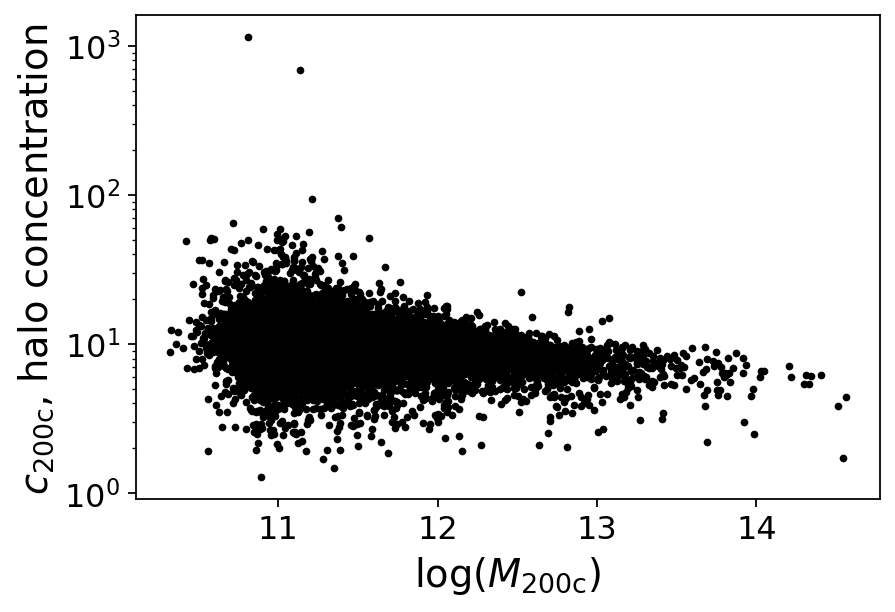

In [8]:
plt.scatter(sim_reader.x_catalog_features[:,0], sim_reader.x_catalog_features[:,1], s=6, c='k')
plt.yscale('log')
plt.xlabel(r'log($M_\mathrm{200c}$)')
plt.ylabel('$c_\mathrm{200c}$, halo concentration ')

(0.0, 1.0)

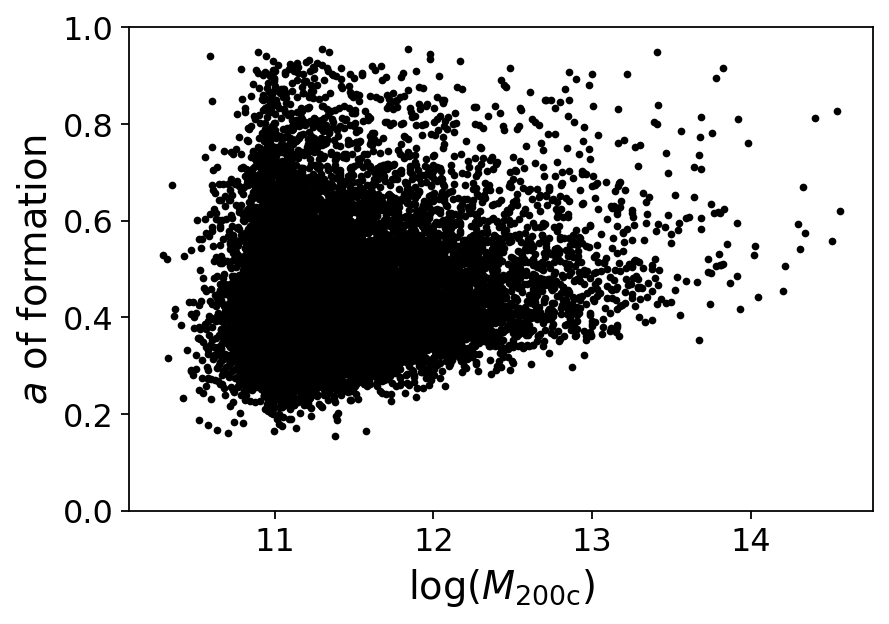

In [9]:
plt.scatter(sim_reader.x_catalog_features[:,0], sim_reader.x_catalog_features[:,2], s=6, c='k')
plt.xlabel(r'log($M_\mathrm{200c}$)')
plt.ylabel('$a$ of formation')
plt.ylim(0, 1)

## Set up fit

### Uncertainties

In [10]:
logmstellar_bins = np.linspace(8.5, 11, 6)
logmstellar_bins = np.array([5] + list(logmstellar_bins) + [13])
# added estimates on either end (low: double, high: extend)
stdev_dict = {'TNG50-4': np.array([0.56, 0.28, 0.23, 0.12, 0.05, 0.04, 0.04]), # epsilon=4, similar to tng50-4
              'TNG100-1': np.array([0.16, 0.08, 0.06, 0.04, 0.03, 0.04, 0.04]), # epsilon=1, similar to tng100-1
             }

idxs_mbins = np.digitize(log_m_stellar+log_mass_shift, logmstellar_bins)
uncertainties_genel2019 = stdev_dict[sim_name][idxs_mbins-1]
# hack to deal with 0-stellar-mass objects - give them the minimum uncertainty of the others 
uncertainties_genel2019[uncertainties_genel2019==0] = min(uncertainties_genel2019)

### Powerlaw

In [11]:
def broken_power_law(log_M200, N=1, log_M1=12-log_mass_shift, beta=1, gamma=1):
    return log_M200 + np.log10( 2*N/((log_M200/log_M1)**(-beta) + (log_M200/log_M1)**gamma) )

In [12]:
M1 = 12-log_mass_shift
p0 = [0.01, M1, 1.5, 0.4]
bounds = [[0]*len(p0), [np.inf]*len(p0)]
popt, _ = curve_fit(broken_power_law, log_m_200m, log_m_stellar, sigma=uncertainties_genel2019, 
                    bounds=bounds, p0=p0)
y_val_current_powerlaw_fit = broken_power_law(log_m_200m, *popt)

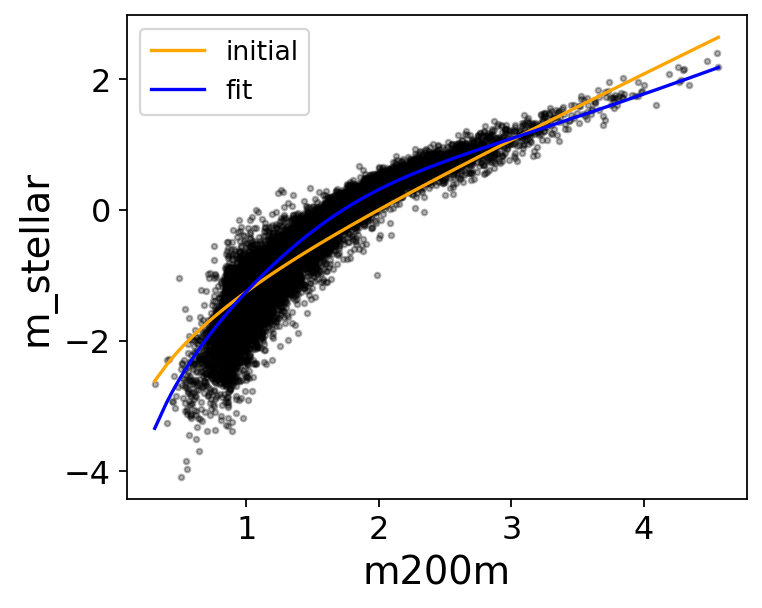

In [13]:
plt.figure(figsize=(5,4))
# sort for plotting niceness
idx_m_200m = np.argsort(log_m_200m)
y_initial = broken_power_law(log_m_200m, *p0)
plt.scatter(log_m_200m[idx_m_200m], log_m_stellar[idx_m_200m], s=6, c='k', alpha=0.3)
plt.plot(log_m_200m[idx_m_200m], y_initial[idx_m_200m], color='orange', label='initial')
plt.plot(log_m_200m[idx_m_200m], y_val_current_powerlaw_fit[idx_m_200m], color='blue', label='fit')
plt.xlabel('m200m')
plt.ylabel('m_stellar')
plt.legend(fontsize=12)

In [14]:
# Deleting nan entries for now
x_catalog_features = np.delete(sim_reader.x_catalog_features, idxs_nan_structure_catalog, axis=0)
y_scalar = np.delete(log_m_stellar, idxs_nan_structure_catalog, axis=0)
y_val_current_powerlaw_fit = np.delete(y_val_current_powerlaw_fit, idxs_nan_structure_catalog, axis=0)
uncertainties_genel2019 = np.delete(uncertainties_genel2019, idxs_nan_structure_catalog, axis=0)

## Do fit

In [36]:
x_catalog_features.shape, y_scalar.shape

((20002, 3), (20002,))

scale fit
pred test
pred train


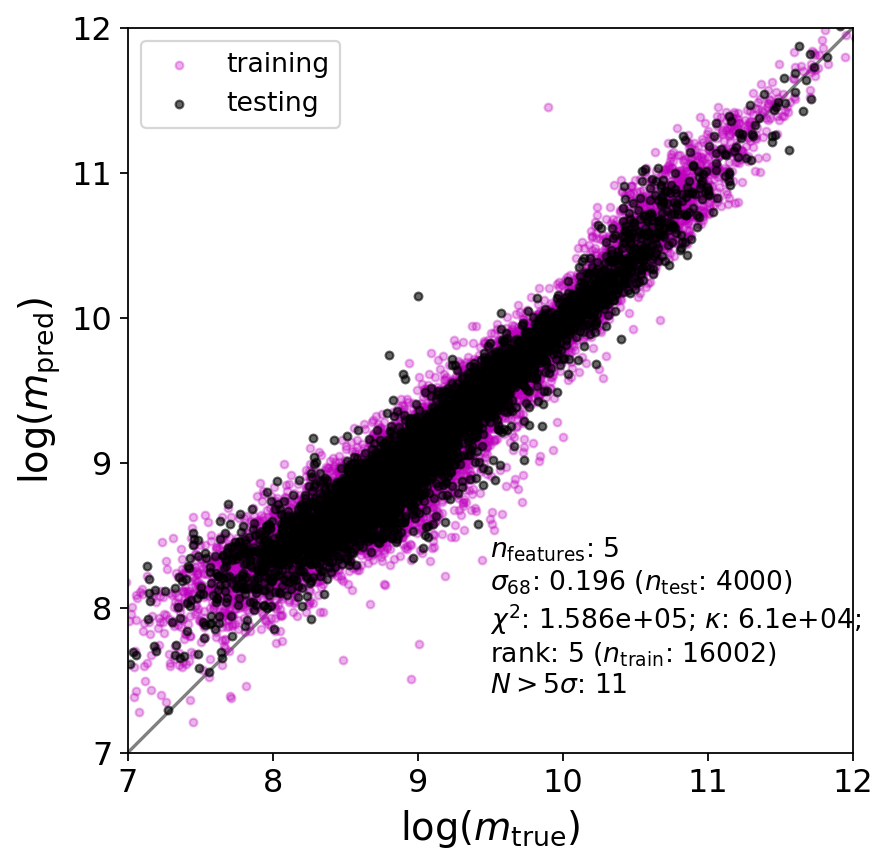

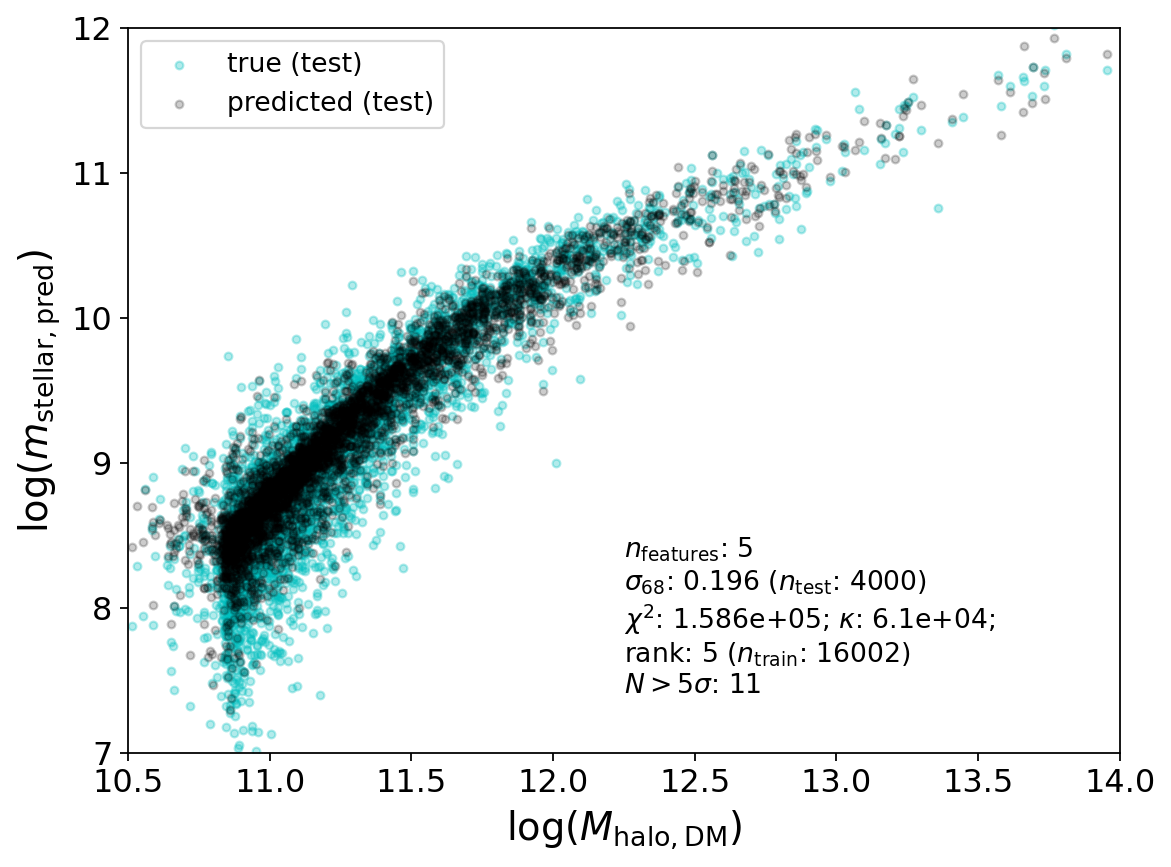

In [39]:
fitter = Fitter(x_catalog_features, y_scalar, 
                y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019)
fit_and_plot(fitter, log_m_200m)

# Neural network

In [75]:
nnfitter = NNFitter(x_catalog_features, y_scalar, 
                y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019)
nnfitter.split_train_test()
nnfitter.set_up_data()

In [76]:
nnfitter.train()

Epoch 0: train loss: 1.2520289421081543
Epoch 1: train loss: 1.4189257621765137
Epoch 2: train loss: 1.1506094932556152
Epoch 3: train loss: 0.8849281072616577
Epoch 4: train loss: 0.3726111054420471
Epoch 5: train loss: 0.32767975330352783
Epoch 6: train loss: 0.37999963760375977
Epoch 7: train loss: 0.20437213778495789
Epoch 8: train loss: 0.19926151633262634
Epoch 9: train loss: 0.1677885353565216
Epoch 10: train loss: 0.11744893342256546
Epoch 11: train loss: 0.05319534242153168
Epoch 12: train loss: 0.04401542991399765
Epoch 13: train loss: 0.04178904742002487
Epoch 14: train loss: 0.06347674876451492
Epoch 15: train loss: 0.13505679368972778
Epoch 16: train loss: 0.14972023665905
Epoch 17: train loss: 0.12374459952116013
Epoch 18: train loss: 0.14178048074245453
Epoch 19: train loss: 0.1494656205177307
Epoch 20: train loss: 0.11631246656179428
Epoch 21: train loss: 0.07724937051534653
Epoch 22: train loss: 0.07844866067171097
Epoch 23: train loss: 0.05810000002384186
Epoch 24: tr

Epoch 223: train loss: 0.02670467458665371
Epoch 224: train loss: 0.029205666854977608
Epoch 225: train loss: 0.03462853282690048
Epoch 226: train loss: 0.05670734867453575
Epoch 227: train loss: 0.01771927997469902
Epoch 228: train loss: 0.07563971728086472
Epoch 229: train loss: 0.037836749106645584
Epoch 230: train loss: 0.03127387911081314
Epoch 231: train loss: 0.031244760379195213
Epoch 232: train loss: 0.04488753899931908
Epoch 233: train loss: 0.046503324061632156
Epoch 234: train loss: 0.04135860875248909
Epoch 235: train loss: 0.02057204768061638
Epoch 236: train loss: 0.03181122988462448
Epoch 237: train loss: 0.03716878220438957
Epoch 238: train loss: 0.029955409467220306
Epoch 239: train loss: 0.05928567051887512
Epoch 240: train loss: 0.028309300541877747
Epoch 241: train loss: 0.02780826762318611
Epoch 242: train loss: 0.038693867623806
Epoch 243: train loss: 0.03497804328799248
Epoch 244: train loss: 0.06057528778910637
Epoch 245: train loss: 0.05339845269918442
Epoch 2

Epoch 444: train loss: 0.03962426260113716
Epoch 445: train loss: 0.029051175341010094
Epoch 446: train loss: 0.03967601805925369
Epoch 447: train loss: 0.07674334198236465
Epoch 448: train loss: 0.03306848928332329
Epoch 449: train loss: 0.03213287144899368
Epoch 450: train loss: 0.02153107151389122
Epoch 451: train loss: 0.06621091067790985
Epoch 452: train loss: 0.06135072559118271
Epoch 453: train loss: 0.03607592731714249
Epoch 454: train loss: 0.04685730114579201
Epoch 455: train loss: 0.031048061326146126
Epoch 456: train loss: 0.03297748789191246
Epoch 457: train loss: 0.07587401568889618
Epoch 458: train loss: 0.031939417123794556
Epoch 459: train loss: 0.041050445288419724
Epoch 460: train loss: 0.03807053714990616
Epoch 461: train loss: 0.032297201454639435
Epoch 462: train loss: 0.02141532115638256
Epoch 463: train loss: 0.06384426355361938
Epoch 464: train loss: 0.02626391127705574
Epoch 465: train loss: 0.053169213235378265
Epoch 466: train loss: 0.03985222056508064
Epoch

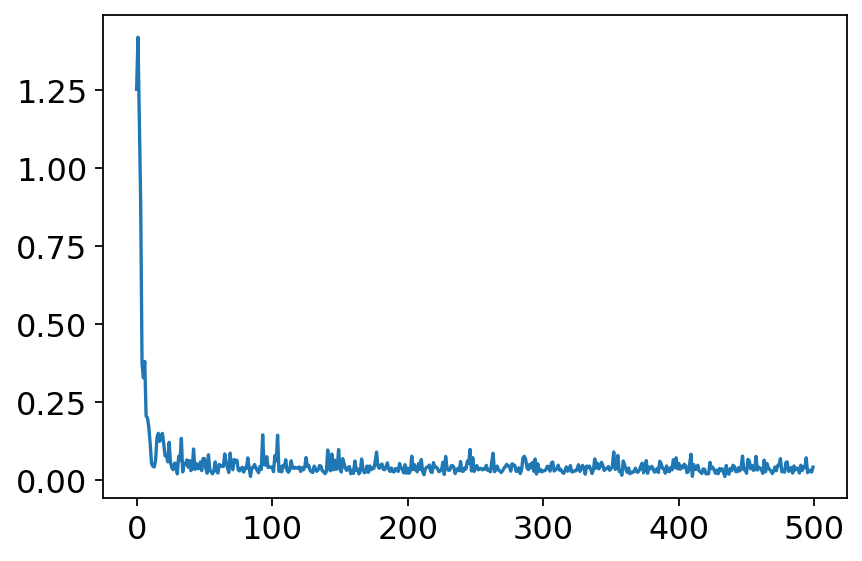

In [77]:
plt.plot(nnfitter.loss)

In [78]:
nnfitter.predict_test()

pred train
[-0.05124688 -0.2710551  -0.03370035 ...  0.21137083  0.09394553
 -0.03333485]
0.16989662408828735


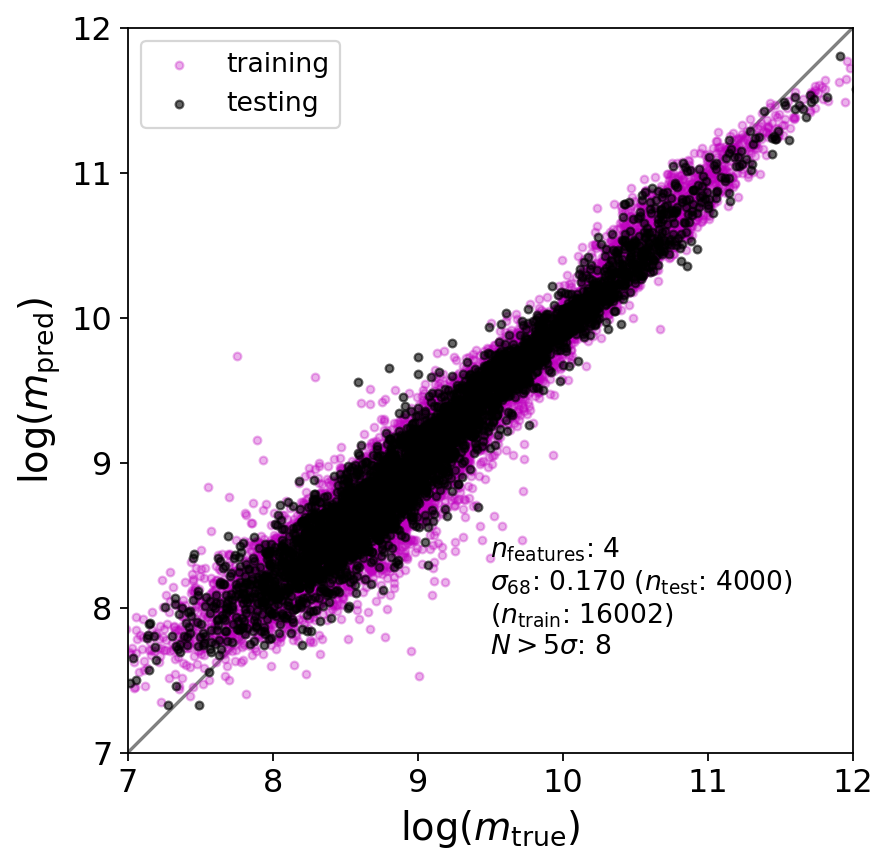

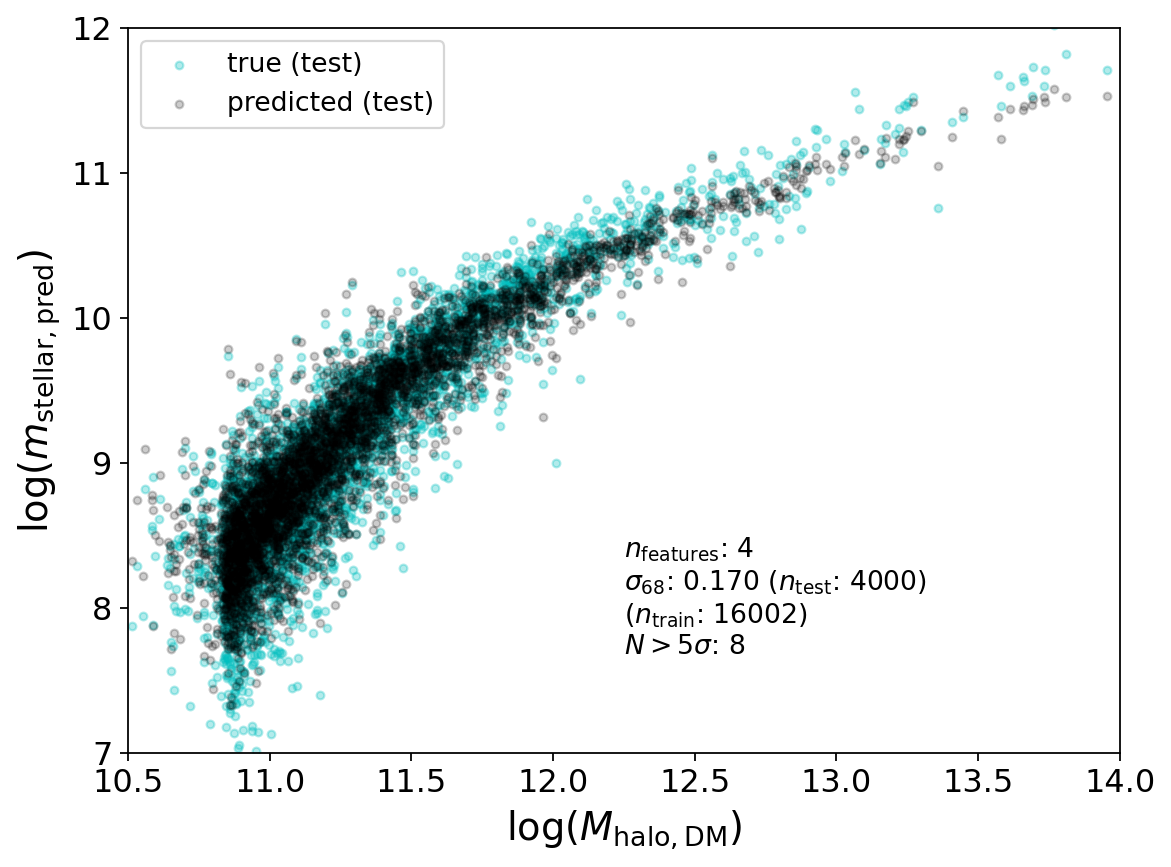

In [79]:
plot(nnfitter, log_m_200m)